In [1]:
%matplotlib inline
from vis_common import load_frame, plot_dict, STORE
f = load_frame(include=['visited_', 'saw_'])
ilost = STORE['ilost']

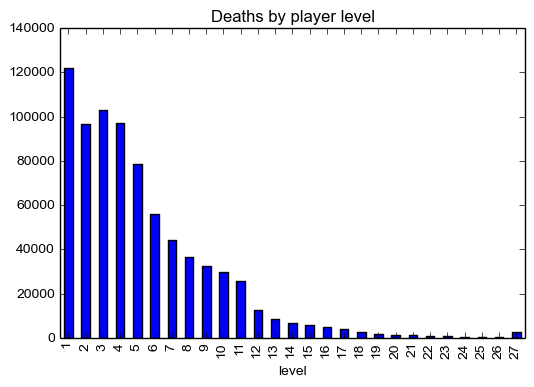

In [2]:
f.loc[ilost].groupby('level').size().plot.bar(title='Deaths by player level');
# Related: chance of dying at level X

Note that this is after filtering out games that were quit at player level 1 (of which there are a loooot - see below). If those were included, the first bar would be about 50% higher.

In [3]:
# Naive visualization. Gets pretty messy cause there are just too many places.
if 0:
    x = f[ilost].groupby(['level', 'wheredied']).size().unstack()
    x = x.div(x.sum(axis=1), axis=0)
    x.plot.area(figsize=(13,9), stacked=True, legend=1);

In [4]:
canon_deathplaces = {'abyss', 'crypt', 'depths',
    'dungeon', 'elven halls', 'lair of beasts',
    'orcish mines', 'pandemonium', 'pits of slime', 'realm of zot',
    'shoals', 'snake pit', 'spider nest', 'swamp', 'tomb', 'vaults',
    'ziggurat',
}
portal_vaults = {'bailey', 'volcano', 'desolation of salt', 'labyrinth', 'ossuary', 'sewer', 'ice cave', 'wizlab'}
silly = {'bazaar', 'ecumenical temple', 'treasure trove',} # Dying in these places is really, really rare
# TODO: it'd be nice to do some of this cleaning earlier in the pipeline (specifically, the non-lossy
# translations, like merging "tomb" and "tomb of the ancients", and "spiders nest", "spider's nest")
canonized_deathplaces = {
    "cigotuvi's fleshworks": "wizlab",
    "doroklohe's tomb": "wizlab",
    "wucad mu's monastery": "wizlab",
    "wizard's laboratory": "wizlab",
    "zonguldrok's shrine": "wizlab",
    "gehenna": "hell",
    "iron city of dis": "hell",
    "sewers": "sewer",
    "spider's nest": "spider nest",
    "tartarus": "hell",
    "tomb of the ancients": "tomb",
    "vestibule of hell": "hell",
}
def get_canon_deathplace(wd):
    mapped = canonized_deathplaces.get(wd, wd)
    if mapped in canon_deathplaces:
        return mapped
    if mapped in silly:
        return None #'silly place'
    if mapped in portal_vaults:
        return 'portal vault'
    return canonized_deathplaces.get(wd, None)

/usr/local/lib/python2.7/dist-packages/pandas/core/categorical.py:952: FutureWarning: 
Setting NaNs in `categories` is deprecated and will be removed in a future version of pandas.
  ordered=self.ordered)
/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


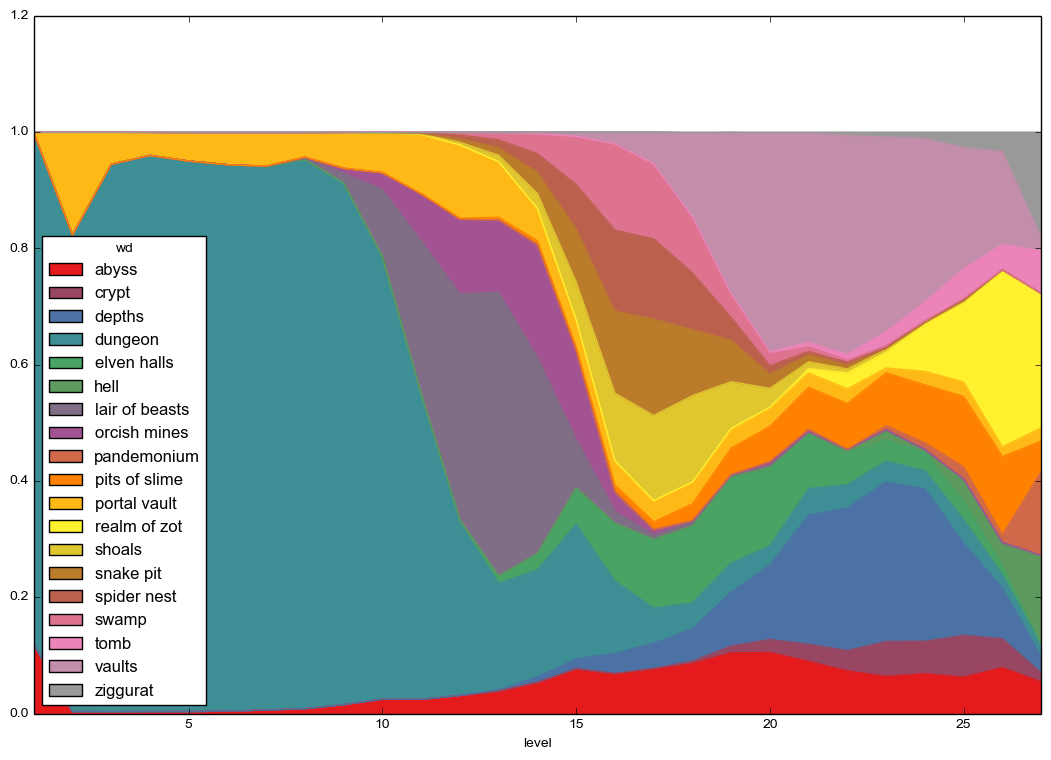

In [5]:
x = f[['level', 'wheredied']].loc[ilost].assign(wd=f['wheredied'].map(get_canon_deathplace))\
    .groupby(['level', 'wd']).size().unstack()
x = x.div(x.sum(axis=1), axis=0)
x.plot.area(figsize=(13,9), stacked=True, legend=1, colormap='Set1');
# TODO: Would be nice to colour these in some kind of logical way. e.g. lair branches all
# shades of the same colour, same with dungeon/depths/zot, orc/elven, pan/hell, and crypt/tomb
# TODO: would also be nice to order them logically
# TODO: legend is kind of in the way, and top margin is silly
del x

In [6]:
# I'm kind of surprised there isn't a bit of a bounce for the dungeon in the endgame
# from people dying during the orb run. I guess it's not that lethal in the grand
# scheme of things. Oh, should collect that data.

In [7]:
visit_cols = [col for col in f.columns if col.startswith('visited_')]
visited_to_wheredied = {
    'bailey': 'bailey',
    'desolation': 'desolation of salt',
    'ice cave': 'ice cave',
    'labyrinth': 'labyrinth',
    'ossuary': 'ossuary',
    'sewer': 'sewer',
    'volcano': 'volcano',
    'wizlab': "wizard's laboratory",
}

# Probably a clever way to do this w/o explicit looping, but whatever
vault_deadliness = {}
for (v, w) in visited_to_wheredied.iteritems():
    deaths = len(f[f['wheredied'] == w])
    visits = len(f[f['visited_'+v] == True])
    vault_deadliness[v] = 100 * deaths/(visits+0.0)
print vault_deadliness

{'ossuary': 11.652777281018635, 'labyrinth': 7.054521991612002, 'desolation': 17.99163179916318, 'wizlab': 4.645161290322581, 'ice cave': 15.795317849541963, 'sewer': 10.016969198333934, 'bailey': 20.339984247834078, 'volcano': 7.034250960307299}


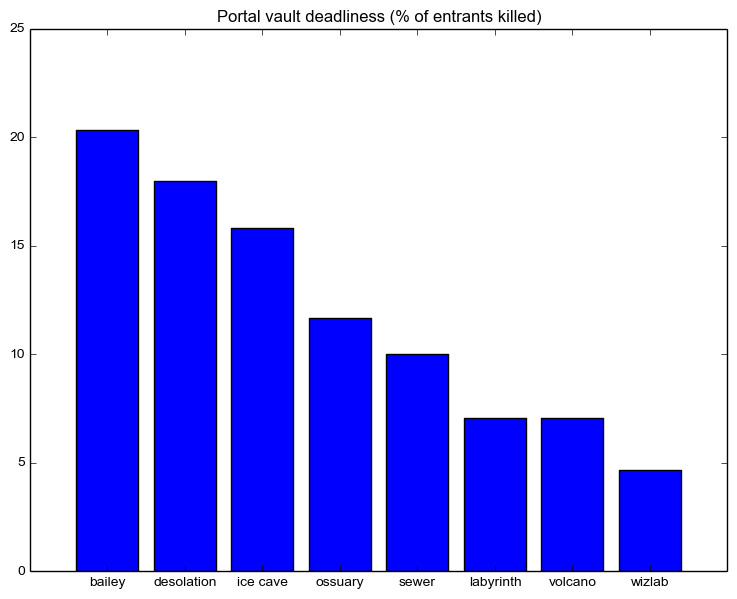

In [8]:
plot_dict(vault_deadliness, 'Portal vault deadliness (% of entrants killed)');
# Main trend here seems to be that vaults that appear later in the game have lower
# lethality. This is probably less a property of the vaults themselves and more a
# byproduct of how deaths are front-loaded to early player levels, and that players who
# are able to make it as far as a wizlab are very skilled.
# Would be cool to have some notion of 'level-adjusted deadliness'. Also for monsters.

# It's kind of surprising to me just how high these numbers are. But maybe the numbers
# would also be surprisingly high for just stuff like "D:8 deadliness"

In [9]:
f.groupby('howdied').size().sort_values(ascending=False)

howdied
monster        737798
quit            31453
suicide          4848
cloud            2920
starved          1000
miscast           399
drowned           380
asphyxiated       196
rot               106
statdeath          35
dtype: int64

One possible takeaway from the above is that starvation isn't really much of an existential threat in crawl, and that maybe food should be made more rare. While I do think this is true, the above doesn't really represent a strong argument for that, because you might be more likely to die to a monster as a result of the symptoms of being on the brink of starvation death (nocast, combat penalties, fainting) before you die of starvation directly.

Could test that case by recording satiety level on death and counting how often people die while at 'starving' level hunger.

In [10]:
f[f['saw_temple']==True].groupby('howdied').size().sort_values(ascending=False)

howdied
monster        184363
quit             2827
cloud            1053
suicide           849
starved           359
drowned           252
miscast           121
asphyxiated        43
statdeath          18
rot                 9
dtype: int64

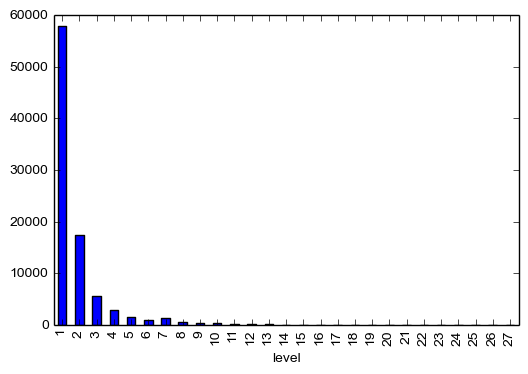

In [11]:
fr = load_frame(raw=True)
fr[fr['howdied'] == 'quit'].groupby('level').size().plot.bar();
del fr
# A lot of people quit at level 1, and I don't know why. Like a loooot.
# TODO: You should figure out why. See if any variables correlate with
# quitting/early quitting. Playing a development version? Certain 
# species/bgs that lend themselves to some kind of early game scumming?

In [13]:
#f['wheredied'].value_counts()

dungeon                                654049
lair of beasts                          22927
abyss                                   21692
orcish mines                             8426
sewer                                    3896
vaults                                   3428
ice cave                                 3414
ossuary                                  3258
bailey                                   3099
snake pit                                2890
elven halls                              2841
swamp                                    2574
shoals                                   2539
spider nest                              2513
depths                                   2199
labyrinth                                1312
pits of slime                            1130
realm of zot                              985
volcano                                   879
ziggurat                                  559
ecumenical temple                         530
sewers                            